In [1]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization

from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Concatenate, Attention

from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler


2024-02-05 21:50:28.272912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import yfinance as yf

In [3]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [4]:
#period = '3000d'
period = 'max'


features = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
#features = [ 'Close' ]  # Sadece kapanış fiyatını kullanın

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

tickers = ['SOL-USD']




In [5]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)

            veri = veri[features]   
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
            
            
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [6]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [7]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed
SOL-USD verisi csv olarak kaydedildi


In [8]:
scaler  = MinMaxScaler()

#her bir veri çerçevesi için scaled dataset oluştur

if not os.path.exists('datas/scaled_datasets'):
    os.makedirs('datas/scaled_datasets')

scaled_datasets = []

for i in range(len(datasets)):
    scaled_datasets.append(scaler.fit_transform(datasets[i]))
    np.save(f'datas/scaled_datasets/{tickers[i]}.npy', scaled_datasets[i])
    print(f'{tickers[i]} verisi scaled edilerek kaydedildi')
    

SOL-USD verisi scaled edilerek kaydedildi


In [9]:
# her bir veri çerçevesi için veriyi dizilere bölme

seq_length = 60  # Son 60 günü kullanarak
pred_length = 7  # Önümüzdeki 7 günü tahmin etme

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

# her bir veri çerçevesi için veriyi dizilere bölme

if not os.path.exists('datas/sequences'):
    os.makedirs('datas/sequences')

X, y = [], []

for i in range(len(scaled_datasets)):
    X_, y_ = create_sequences(scaled_datasets[i], seq_length, pred_length)
    X.append(X_)
    y.append(y_)
    np.save(f'datas/sequences/X_{tickers[i]}.npy', X_)
    np.save(f'datas/sequences/y_{tickers[i]}.npy', y_)
    print(f'{tickers[i]} verisi dizilere bölünerek kaydedildi')
    


SOL-USD verisi dizilere bölünerek kaydedildi


In [10]:
# her bir veri çerçevesi için  seq2seq attention modeli oluştur


# Encoder

encoder_inputs = Input(shape=(seq_length, len(features)))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = RepeatVector(pred_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


# Dikkat Mekanizması
attention_layer = Attention(use_scale=True)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])


# TimeDistributed Dense
decoder_dense = TimeDistributed(Dense(len(features)))
decoder_outputs = decoder_dense(decoder_concat_input)

def create_model(encoder_inputs, decoder_outputs):
    model = Model(encoder_inputs, decoder_outputs)
    return model
    


In [11]:
encoder_inputs.shape

TensorShape([None, 60, 6])

In [12]:
# her bir veri çerçevesi için modeli oluştur ve eğit

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

models = []
batch_size = 60
epochs = 20

for i in range(len(scaled_datasets)):
    # modeli oluştur
    model = create_model(encoder_inputs, decoder_outputs)
    
    # modeli derle
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # modeli listeye ekle
    models.append(model)
    
    # modeli eğit
    models[i].fit(X[i], y[i],
                  batch_size=batch_size, epochs=epochs, 
                  
                  #validation_split=0.2, 
                  
                  verbose=1)
    
    # modeli kaydet
    models[i].save(f'datas/models/{tickers[i]}_model.h5')
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')


Epoch 1/20


2024-02-05 21:50:39.315133: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


23/23 [==============================] - 6s 36ms/step - loss: 0.0167
Epoch 2/20
23/23 [==============================] - 1s 32ms/step - loss: 0.0027
Epoch 3/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0022
Epoch 4/20
23/23 [==============================] - 1s 32ms/step - loss: 0.0021
Epoch 5/20
23/23 [==============================] - 1s 31ms/step - loss: 0.0019
Epoch 6/20
23/23 [==============================] - 1s 32ms/step - loss: 0.0021
Epoch 7/20
23/23 [==============================] - 1s 34ms/step - loss: 0.0019
Epoch 8/20
23/23 [==============================] - 1s 34ms/step - loss: 0.0020
Epoch 9/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0020
Epoch 10/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0017
Epoch 11/20
23/23 [==============================] - 1s 33ms/step - loss: 0.0017
Epoch 12/20
23/23 [==============================] - 1s 31ms/step - loss: 0.0017
Epoch 13/20
23/23 [=============================

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


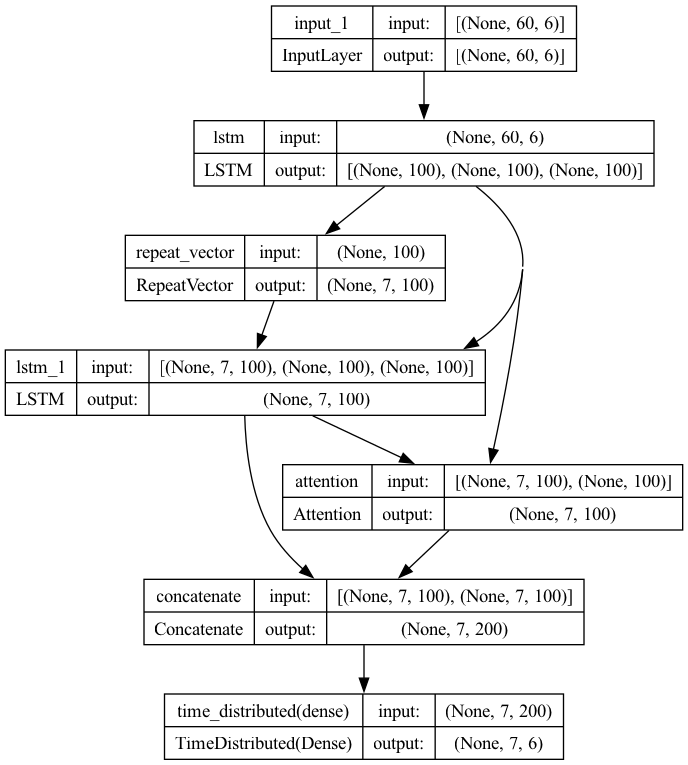

In [13]:
# modelerden bir tanesini png kaydedelim
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='datas/model.png', show_shapes=True, show_layer_names=True , rankdir='TB', expand_nested=True, dpi=96, )

In [14]:
# model summary 
models[0].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 6)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 100),                42800     ['input_1[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector (RepeatVecto  (None, 7, 100)               0         ['lstm[0][0]']                
 r)                                                                                           

In [15]:
# TODO : 
# soru = bu none girişler nereden geliyor ?
# cevap = 

In [16]:
# her bir veri çerçevesi için last_sequence = data_scaled[-seq_length:] mantığında prediction yap

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
predictions = []    

for i in range(len(scaled_datasets)):
    last_sequence = scaled_datasets[i][-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    # buradaki 1 seq_length, len(features) şeklinde olması ne işe yarıyor : ? 
    # cevap = 
    predicted = models[i].predict(last_sequence)
    
    predictions.append(predicted)
    np.save(f'datas/predictions/{tickers[i]}_prediction.npy', predicted)
    print(f'{tickers[i]} verisi için prediction yapıldı ve kaydedildi')
    

1/1 [==============================] - 1s 953ms/step
SOL-USD verisi için prediction yapıldı ve kaydedildi


2024-02-05 21:50:56.247304: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [17]:
# her bir veri çerçevesi için bütün sütunları predictionları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/forecasts'):
    os.makedirs('datas/forecasts')
    
forecasts = []

for i in range(len(scaled_datasets)):
    prediction = np.load(f'datas/predictions/{tickers[i]}_prediction.npy')
    
    
    prediction = scaler.inverse_transform(prediction.reshape(-1, len(features) ))
    forecasts.append(prediction)
    np.save(f'datas/forecasts/{tickers[i]}_forecast.npy', prediction)
    print(f'{tickers[i]} verisi için forecast yapıldı ve kaydedildi')
    print(forecasts[i].shape)
    
# dataframe oluştur

for i in range(len(forecasts)):
    forecast = forecasts[i]
    forecast_dates = datasets[i].index[-pred_length:]
    forecast = pd.DataFrame(forecast, index=forecast_dates, columns=features)
    forecast.to_csv(f'datas/forecasts/{tickers[i]}_forecast.csv')
    print(f'{tickers[i]} verisi için forecast dataframe oluşturuldu ve kaydedildi')


    

SOL-USD verisi için forecast yapıldı ve kaydedildi
(7, 6)
SOL-USD verisi için forecast dataframe oluşturuldu ve kaydedildi


In [18]:
#dataframeleri bi yazdır tarihleri ile

for i in range(len(forecasts)):
    forecast = pd.read_csv(f'datas/forecasts/{tickers[i]}_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için forecast dataframe')
    print(forecast)

SOL-USD verisi için forecast dataframe
                  Open        High        Low       Close   Adj Close  \
Date                                                                    
2024-01-30   97.838320  104.682900   95.39071  100.546840   97.012115   
2024-01-31  102.092865  110.263626   99.90977  106.506256  102.870220   
2024-02-01  104.144640  112.938950  102.08743  108.957550  105.253120   
2024-02-02  105.273796  114.395520  103.37108  110.183260  106.398415   
2024-02-03  106.133230  115.491210  104.42179  111.158480  107.291280   
2024-02-04  106.980630  116.572990  105.46654  112.203360  108.268680   
2024-02-05  107.892746  117.749084  106.55373  113.370580  109.396164   

                  Volume  
Date                      
2024-01-30  2.400421e+09  
2024-01-31  2.534816e+09  
2024-02-01  2.595827e+09  
2024-02-02  2.626101e+09  
2024-02-03  2.650068e+09  
2024-02-04  2.677068e+09  
2024-02-05  2.709259e+09  


In [19]:
# Gerçek veriyi yazdır aynı tarihteki 

for i in range(len(datasets)):
    print(f'{tickers[i]} verisi için gerçek veri')
    print(datasets[i].tail(pred_length))


SOL-USD verisi için gerçek veri
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-01-30  101.566666  106.213455  101.109390  101.472977  101.472977   
2024-01-31  101.449257  102.548065   96.103592   97.028709   97.028709   
2024-02-01   97.024841   97.944191   93.379189   97.846695   97.846695   
2024-02-02   97.834694  102.412628   97.574158  100.440521  100.440521   
2024-02-03  100.451134  101.058983   96.812576   97.879982   97.879982   
2024-02-04   97.885063   98.457588   95.266373   95.476959   95.476959   
2024-02-05   95.471466   98.480896   94.510674   95.549156   95.549156   

                Volume  
Date                    
2024-01-30  3328090833  
2024-01-31  3814467068  
2024-02-01  2951395444  
2024-02-02  2574044077  
2024-02-03  1349320819  
2024-02-04  1304106726  
2024-02-05  1705993088  


## 2. Kısım

In [20]:
# her bir veri çerçevesi için eğitime uygun full data hazırla (tensor dataset)

if not os.path.exists('datas/full_data'):
    os.makedirs('datas/full_data')
    
full_data = []

for i in range(len(scaled_datasets)):
    
    scaled_dataset_all = np.load(f'datas/scaled_datasets/{tickers[i]}.npy')
    
    scaled_dataset_all = tf.data.Dataset.from_tensor_slices(scaled_dataset_all)
    
    scaled_dataset_all = tf.data.Dataset.zip((scaled_dataset_all, scaled_dataset_all.skip(seq_length)))
    
    scaled_dataset_all = scaled_dataset_all.batch(seq_length, drop_remainder=True).prefetch(1)

    scaled_dataset_all = scaled_dataset_all.cache(f'datas/full_data/{tickers[i]}_full_data')


    
    full_data.append(scaled_dataset_all)
    
    #full_data[i] = full_data[i].batch(seq_length, drop_remainder=True).prefetch(1)
    
    #full_data[i] = full_data[i].cache(f'datas/full_data/{tickers[i]}_full_data')

    print(f'{tickers[i]} verisi için full data hazırlandı')
    
    
    

SOL-USD verisi için full data hazırlandı


In [21]:
encoder_inputs.shape


TensorShape([None, 60, 6])

In [22]:
full_data[0]

<CacheDataset element_spec=(TensorSpec(shape=(60, 6), dtype=tf.float64, name=None), TensorSpec(shape=(60, 6), dtype=tf.float64, name=None))>

In [24]:
# her bir veri çerçevesi için modeli import et ve eğit

for i in range(len(scaled_datasets)):
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    
    model.fit(full_data[i], epochs=epochs, 
              
              verbose=1)
    
    
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')
    

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.cache_op.CacheDataset'>]

In [ ]:
into_future = 1

def future_forecast(model, data, into_future):
    future_forecast = []
    last_sequence = data[-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    for i in range(into_future):
        predicted = model.predict(last_sequence)
        future_forecast.append(predicted)
        last_sequence = np.append(last_sequence, predicted)
        last_sequence = last_sequence[-seq_length:]
        last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    return future_forecast


In [ ]:
print( into_future , seq_length,)

In [ ]:
future_values = []

if not os.path.exists('datas/future_values'):
    os.makedirs('datas/future_values')

for i in range(len(scaled_datasets)):
    future_values.append(future_forecast(models[i], scaled_datasets[i], into_future))
    np.save(f'datas/future_values/{tickers[i]}_future_values.npy', future_values[i])
    print(f'{tickers[i]} verisi için future values yapıldı ve kaydedildi')
    

In [ ]:
# her bir veri çerçevesi için future valuesları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/future_forecasts'):
    os.makedirs('datas/future_forecasts')
    
future_forecasts = []

for i in range(len(scaled_datasets)):
    
    #np array olarak future values al
    future_value = np.load(f'datas/future_values/{tickers[i]}_future_values.npy')
    future_value = scaler.inverse_transform(future_value.reshape(-1, len(features) ))
    future_forecasts.append(future_value)
    np.save(f'datas/future_forecasts/{tickers[i]}_future_forecast.npy', future_value)
    print(f'{tickers[i]} verisi için future forecast yapıldı ve kaydedildi')
    print(future_forecasts[i].shape)

In [ ]:
print(future_forecasts[0])

In [ ]:
print(into_future) 

In [ ]:

# dataframe oluştur

if not os.path.exists('datas/future_forecasts_df'):
    os.makedirs('datas/future_forecasts_df')

hafta = (into_future*7) + 1

for i in range(len(future_forecasts)):
    future_forecast = future_forecasts[i]
    future_forecast_dates = pd.date_range(start=datasets[i].index[-1], periods=hafta)[1:]
    future_forecast = pd.DataFrame(future_forecast, index=future_forecast_dates, columns=features)
    future_forecast.to_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv')
    print(f'{tickers[i]} verisi için future forecast dataframe oluşturuldu ve kaydedildi')

In [ ]:
# future forecast dataframe leri yazdır

for i in range(len(future_forecasts)):
    future_forecast = pd.read_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için future forecast dataframe')
    print(future_forecast)
    
